<a href="https://colab.research.google.com/github/matheusbarroso/reinforcement_learning/blob/main/bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

from tqdm import tqdm

This notebook is based on the material and examples found at:
 
> Reinforcement Learning: An Introduction. Second edition, in progress. Richard S. Sutton and Andrew G. Barto c 2014, 2015. A Bradford Book. The MIT Press. p.47-54

# Bandit Problem

You are faced repeatedly with a choice among  *k* diferent options, or actions. After each choice you receive a numerical reward chosen from a stationary probability distribution that depends on the action you selected.Your objective is to maximize the expected total reward over some time period, for example,
over 1000 action selections, or time steps.
  
Here, each of the *k* different actions has an expected mean or reward given that the action is selected, that is, the *value* of the action.
For simplicity let us consider the following quantities:
- $A_t$ = action selected on time step *t*
- $R_t$ = reward of selecting *A_t* on time step *t*
- $q_*(a)$ = the value of an arbitrary action *a*, that is, the expected reward given that *a* was selected
  
Thus, we have that:
  

$q_*(a)=E[R_T|A_t=a]$

If $q_*(a)$ was known there was the trivial solution of choosing the actions with high value, though, in reality we do not have. Tha is, we need an estimate of the action value. Let $Q_t(a)$ be the estimated action value *a* at time *t*. We want $Q_t(a)$ to be as close as possible to $q_*(a)$.


We can devise two course actions, namely *exploitation* and *exploration*. In the former we have a *greedy* action where we opt for the higher value of $Q_t(a)$ and the latter we opt for a smaller value which can potentially lead us to improve our estimates of nongreedy actions. *exploitation* maximizes expected reward on the current step though *exploration* may proude higher total reward in the long run.

Now we will cover some methods for estimating the action value:
- *sample average*
- *$\epsilon$-greedy*

Let $I_A(x)$ denote an indicator function, that is:
  
$I_A(x)=\{\frac{1,\  if \ x \in A}{1,\ if\ x \not\in A}$

For the *sample average* case we can estimate the action value by:

$Q_t(a) =\frac{\sum_{i=1}^{t-1}R_i.I_{A_i=a}}{\sum_{i=1}^{t-1}.I_{A_i=a}}$ and if the denominator is zero we can set tie action value to zero.
  
From this estimate we can proceed *greedly* and select the best action values handling ties randomly. Thus, the action selection method is:
$A_t=\underset{a}{\operatorname{argmaxQ_t(a)}}$

  

In the case of *$\epsilon$-greedy* strategy e could sample greedily most of the time and with a small probability $\epsilon$ select uniformly at random from all actions.

# Bandit Implementation

In [2]:
class BanditK():
  '''This class simulates a `k`bandit problem for a fixed number
  of `steps` and `runs`. Some plotting functions are available to plot for instance:
  one sampled reward distribution, the average reward over steps and fraction of
   optimal actions. The decisions are based on epsilon-greedy algorithm.
  '''
  def __init__(self, k=10, runs=30, steps=100, epsilon=[0], random_state=123):
    self.runs = runs
    self.steps = steps
    self.k = k
    self.epsilon = epsilon
    self.rewards = np.zeros((runs, steps, len(epsilon)))
    self.A_a = np.zeros((runs, steps, len(epsilon)))
    self.__a = np.arange(k)
    self.__r = np.random.RandomState(random_state)
    self.q_true_a = self.__r.randn(k)
    self.__run = True
    self.__reward_df = None
    self.__action_df = None
    self.__mult_gauss = (self.__r.multivariate_normal(self.q_true_a,
                                                      np.eye(k),
                                                      steps * runs)
                                 .reshape(-1, steps, k)
    )
    
  def plot_reward_distribution(self):
    '''Plots the sample reward distribution from one of the runs at random
    '''
    sample_run = self.__r.choice(range(self.runs))
    mult_gauss_df = pd.DataFrame(self.__mult_gauss[sample_run])
    mult_gauss_df.columns = ['{}'.format(q + 1) for q in mult_gauss_df.columns]
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
    ax = sns.violinplot(y='value', x='variable', data=mult_gauss_df.melt(), ax=ax)
    ax.set_xlabel('Action')
    ax.set_ylabel('Reward Distribution')
    ax.set_title('Reward Sampled Distribution by Action')
    return ax

  def plot_reward(self):
    '''Plots average run reward by step
    '''
    if self.__run:
      self.run_bandit()
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
    ax = self.__reward_df.plot(ax=ax)
    ax.axhline(self.q_true_a.max(), color='green', label='Maximum Reward')
    ax.set_ylim(0, self.q_true_a.max() + 0.2)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Average reward')
    ax.set_title('Average run reward by step ({} runs)'.format(self.runs)) 
    ax.legend(loc='lower right')
    return ax    
  
  def plot_optimal_action(self):
    '''Plots the optimal action percentage by step
    '''
    if self.__run:
      self.run_bandit()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
    ax = self.__action_df.plot(ax=ax)
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_xlabel('Steps')
    ax.set_ylabel('% Optimal action')
    ax.set_title('Average run optimal action by step ({} runs)'.format(self.runs)) 
    ax.legend(loc='lower right')      
    return ax  

  def plot(self):
    '''Plots a sample of the reward distribution (1 out of `runs`),
    the reward performance plot and optimal action plot
    '''
    # fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,20))
    ax0 = self.plot_reward_distribution()
    ax1 = self.plot_reward()
    ax2 = self.plot_optimal_action()
    

  def step_bandit(self, run, epsilon):
    '''Implements one step of the bandit problem
    '''
    Q_a = np.zeros(self.k)
    N_a = np.zeros(self.k)
    reward = np.zeros(self.steps)
    A_a = np.zeros(self.steps) # A chosen path

    for step in range(self.steps):
      a_max = Q_a.max()
      mask_max = a_max == Q_a
      
      A_choice = self.__r.choice([0, 1], p=[epsilon, 1 - epsilon])
      
      if A_choice:
        A = self.__r.choice(self.__a[mask_max])
      else:
        A = self.__r.choice(self.__a)
      
      R = self.__mult_gauss[run, step, A]
      reward[step] = R
      A_a[step] = A
      N_a[A == self.__a] += 1

      # NewEstimate = OldEstimate + StepSize[Target - OldEstimate]
      Q_a[A == self.__a] += (1/N_a[A == self.__a]) * (R - Q_a[A == self.__a]) 

    return reward, A_a

  def run_bandit(self):
    '''Runs the bandit many `runs` and create some summary frames
    '''
    for run in tqdm(range(self.runs)):
      for idx_ep, epsilon in enumerate(self.epsilon):
        reward, A_a = self.step_bandit(run, epsilon)
        self.rewards[run, :, idx_ep] = reward
        self.A_a[run, :, idx_ep] = A_a

    self.__run = False
    self.__reward_df = pd.DataFrame(self.rewards.mean(axis=0))
    self.__reward_df.columns = ['eps={}'.format(eps) for eps in self.epsilon]

    A_opt = self.__a[self.__a == self.q_true_a.argmax()]
    self.__action_df = pd.DataFrame((bandit.A_a == A_opt).mean(axis=0))
    self.__action_df.columns = ['eps={}'.format(eps) for eps in self.epsilon]

# Numerical comparison *sample average* and  *$\epsilon$-greedy*

Suppose a bandint problem with $k=10$, with $q_*(a)   \sim \mathcal{N}(0,1)\,$ with $R_t   \sim \mathcal{N}(q_*(a),1)\,$

We will start with the same example as the book:

In [3]:
bandit = BanditK(k=10, runs=2000, steps=1000, epsilon=[0, 0.1, 0.01])

100%|██████████| 2000/2000 [07:28<00:00,  4.46it/s]


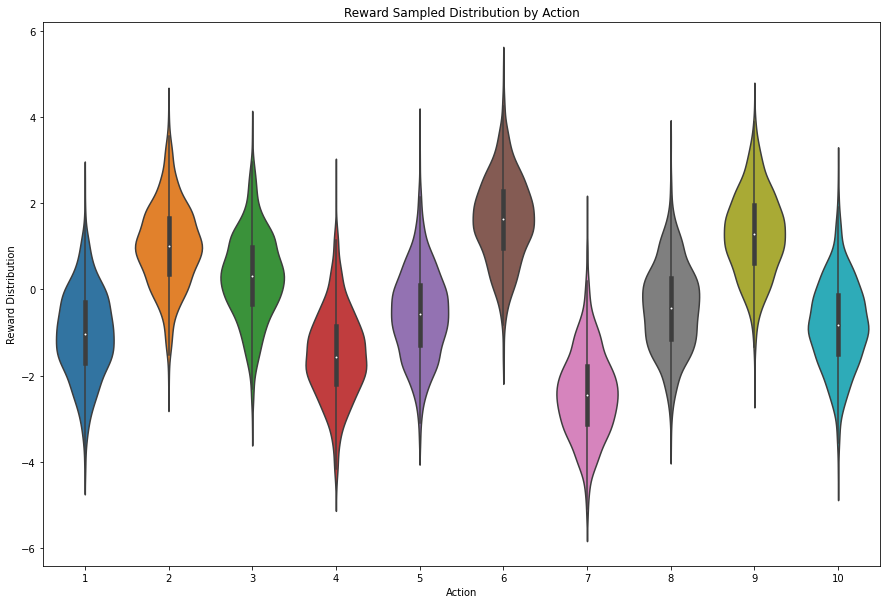

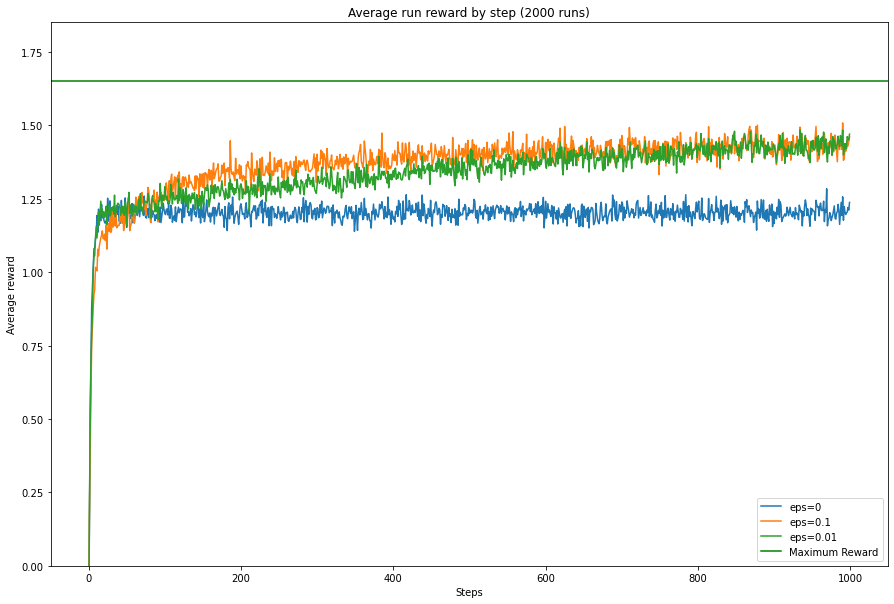

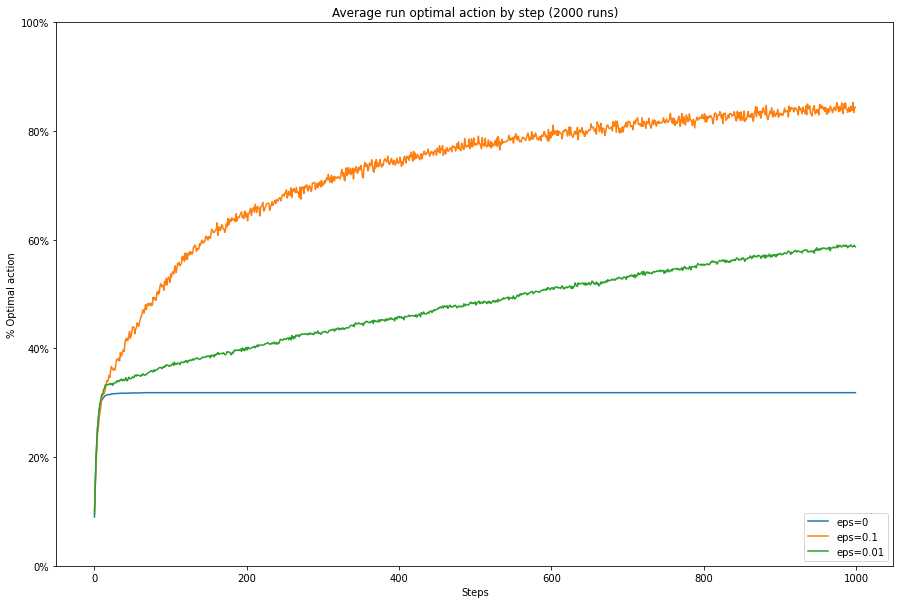

In [4]:
bandit.plot()


Given enough steps for eps=0.01 we will get closer to the true value! (In the long run exploration brings the higher reward)

In [5]:
bandit = BanditK(k=10, runs=1000, steps=5000, epsilon=[0, 0.1, 0.01])

100%|██████████| 1000/1000 [16:23<00:00,  1.02it/s]


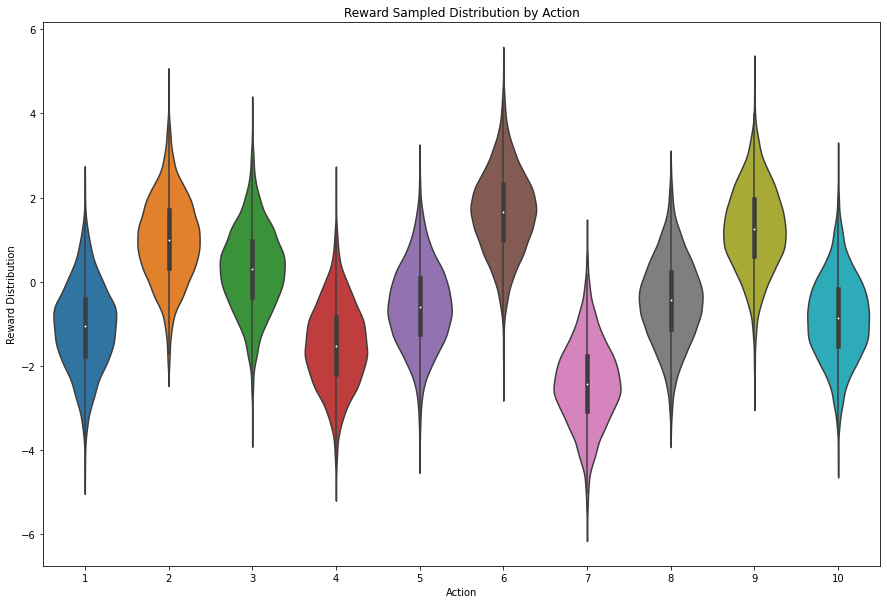

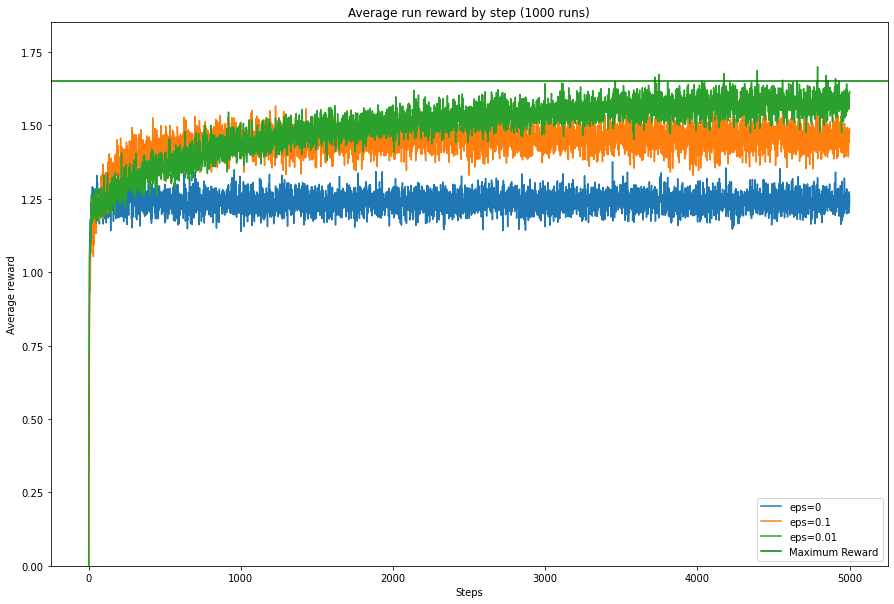

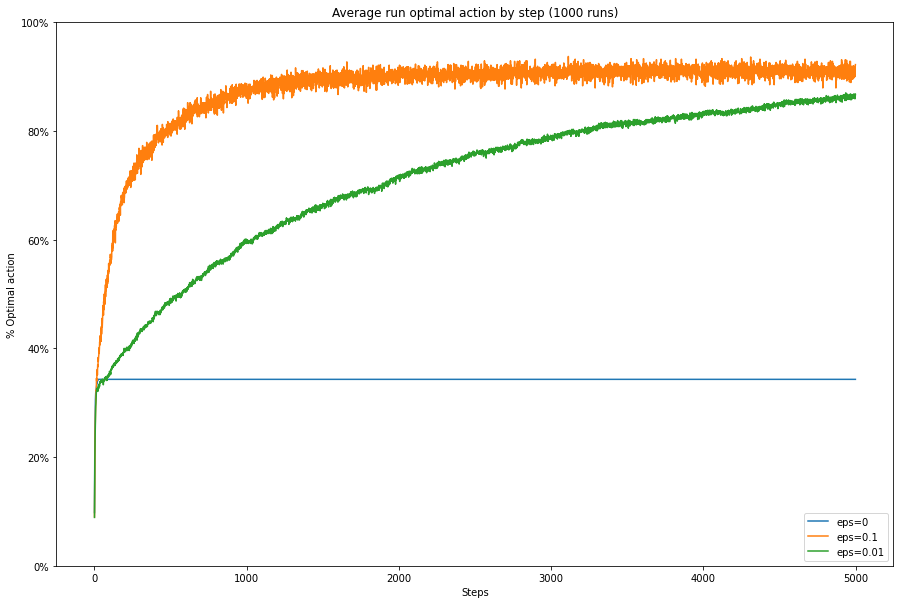

In [6]:
bandit.plot()